<a href="https://colab.research.google.com/github/marciodbotas/MachineLearning/blob/main/3_4_3_PTQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Post Training Quantization
In this Colab we are going to explore Post Training Quantization (PTQ) in more detail. In particular we will use Python to get a sense of what is going on during quantization (effectively peeking under the hood of TensorFlow). We will also visualize the weight distributions to gain intuition for why quantization is often so successful (hint: the weights are often closely clustered around 0).

### First import the needed packages

In [1]:
# For Numpy
import matplotlib.pyplot as plt
import numpy as np
import pprint
import re
import sys
# For TensorFlow Lite (also uses some of the above)
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)
import tensorflow as tf
from tensorflow import keras
import pathlib
import pprint
import re
import sys

DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.


### Exploring Post Training Quantization Algorithms in Python

Let us assume we have a weight array of size (256, 256).

In [2]:
weights = np.random.randn(256, 256)

In Post Training Quantization, we map the 32-bit floating point numbers to 8-bit integers. To do this, we need to find a very important value, the ***scale***. The ***scale*** value is used to convert numbers back and forth between the various representations. For example,  32-bit floating point numbers can be contructed from 8-bit Integers by the following formula:

$ FP32\_Reconstructed\_Value = Scale \times Int8\_value$

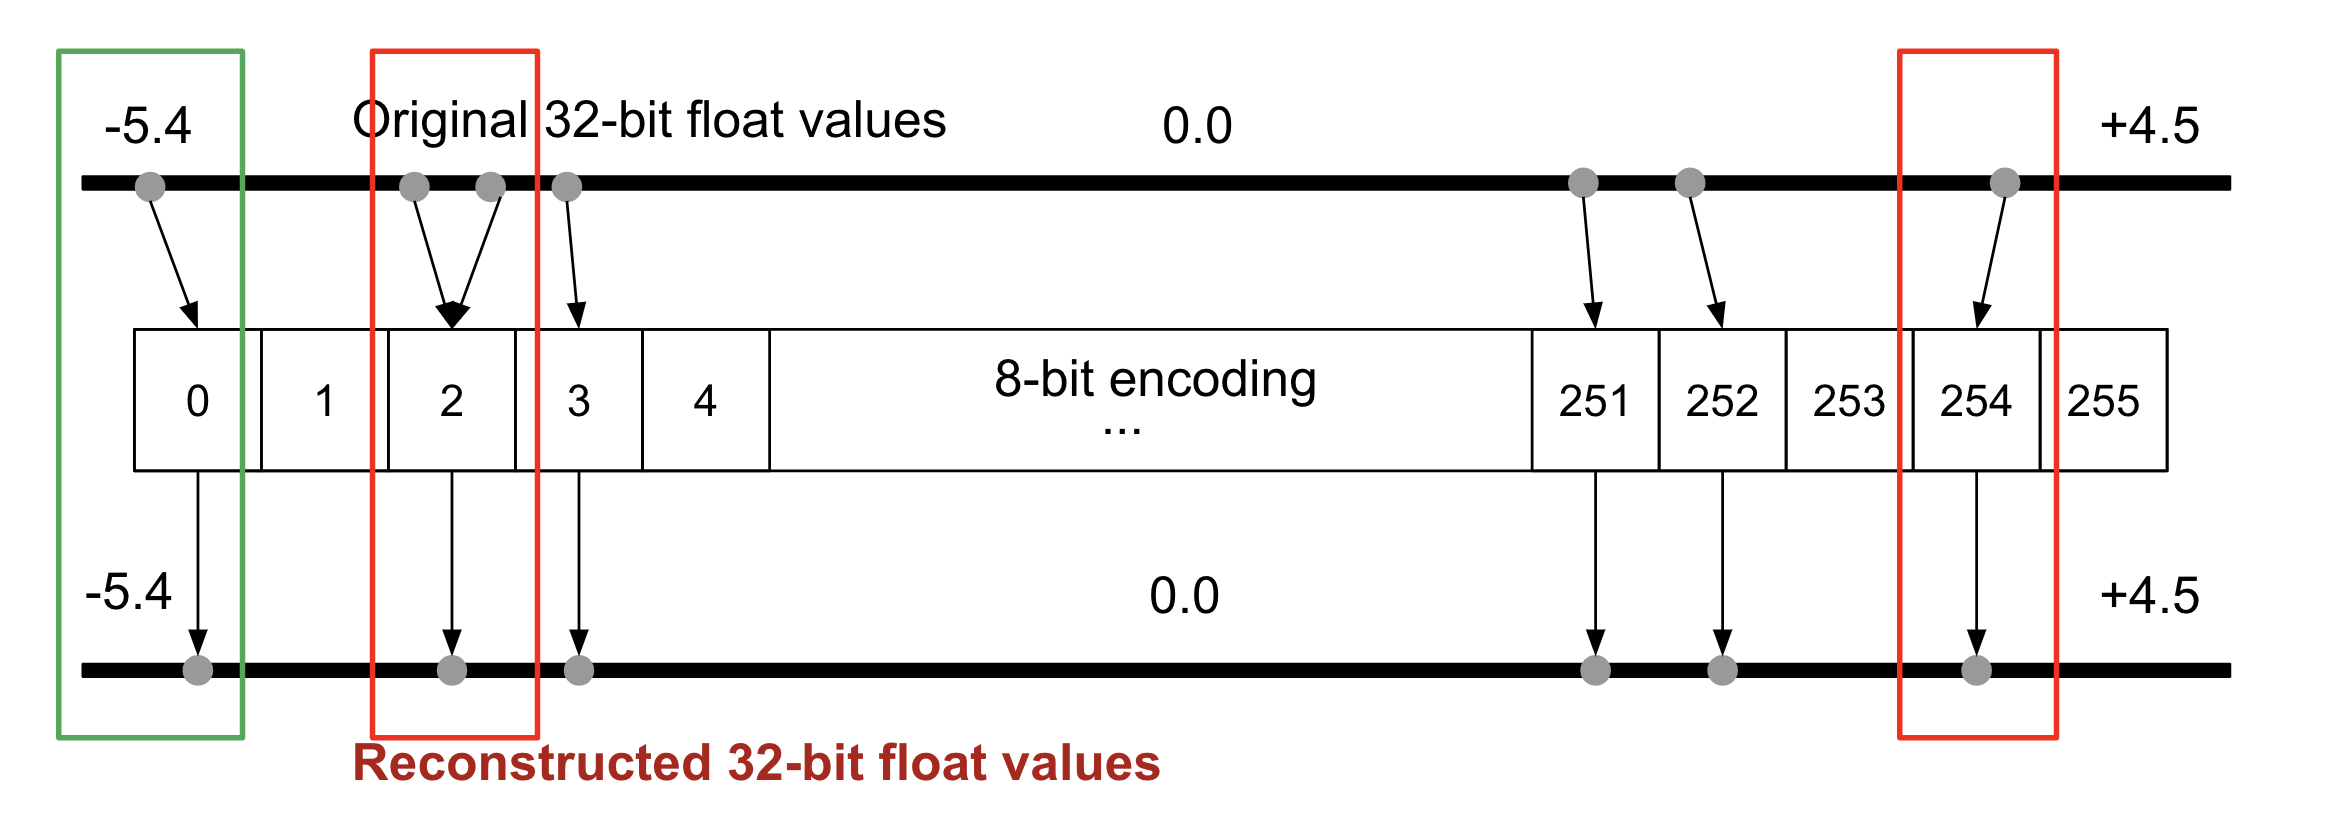


To make sure we can cover the complete weight distribution, the scale value needs to take into account the full range of weight values which we can compute using the following formula. The denominator is 256 because that is the range of values that can be represented using 8-bits ($2^8 = 256$).

$scale = \frac{max(weights) - min(weights)}{256}$

Now lets code this up!

We can then use this function to quantize our weights and then reconstruct them back to floating point format. We can then see what kinds of errors are introduced by this process. Our hope is that the errors in general are small showing that this process does a good job representing our weights in a more compact format. **In general if our scale is smaller it is more likely to have smaller errors as we are not lumping as many numbers into the same bin.**

In [3]:
def quantizeAndReconstruct(weights):
    """
    @param W: np.ndarray

    This function computes the scale value to map fp32 values to int8. The function returns a weight matrix in fp32, that is representable
    using 8-bits.
    """
    # Compute the range of the weight.
    max_weight = np.max(weights)
    min_weight = np.min(weights)
    range = max_weight - min_weight

    max_int8 = 2**8

    # Compute the scale
    scale = range / max_int8

    # Compute the midpoint
    midpoint = np.mean([max_weight, min_weight])

    # Next, we need to map the real fp32 values to the integers. For this, we make use of the computed scale. By diving the weight
    # matrix with the scale, the weight matrix has a range between (-128, 127). Now, we can simply round the full precision numbers
    # to the closest integers.
    centered_weights = weights - midpoint
    quantized_weights = np.rint(centered_weights / scale)

    # Now, we can reconstruct the values back to fp32.
    reconstructed_weights = scale * quantized_weights + midpoint
    return reconstructed_weights

In [4]:
reconstructed_weights = quantizeAndReconstruct(weights)
print("Original weight matrix\n", weights)
print("Weight Matrix after reconstruction\n", reconstructed_weights)
errors = reconstructed_weights-weights
max_error = np.max(errors)
print("Max Error  : ", max_error)
reconstructed_weights.shape

Original weight matrix
 [[ 1.45096402e+00  6.52000999e-01 -1.62944568e-01 ... -1.67913146e+00
  -2.72009652e-01 -4.40023647e-01]
 [ 1.48237344e+00  9.53291444e-01 -5.52660144e-01 ... -1.47771838e-01
  -1.18547492e-01  1.84191668e-01]
 [-5.75440427e-01  2.18918406e+00 -7.21989207e-01 ...  1.15160111e+00
  -6.82943040e-01  1.22143905e+00]
 ...
 [-8.41283171e-01  4.25556843e-01  1.00540026e-03 ...  6.21095257e-01
   6.64751806e-01  1.91555115e-01]
 [ 1.41323046e+00 -5.37193744e-01 -9.70117575e-01 ... -1.62936021e+00
   1.02022537e+00 -2.84330886e+00]
 [-5.63249904e-01  6.12914090e-01 -8.68487762e-02 ... -2.84149375e-01
  -3.62969623e-01 -1.23382741e-01]]
Weight Matrix after reconstruction
 [[ 1.44028187  0.65045853 -0.17227411 ... -1.68610218 -0.27100203
  -0.43554856]
 [ 1.47319117  0.94664228 -0.56718578 ... -0.13936481 -0.1064555
   0.18972825]
 [-0.56718578  2.1971959  -0.73173231 ...  1.14409812 -0.69882301
   1.20991673]
 ...
 [-0.83046023  0.42009339 -0.00772758 ...  0.61754922  0.

(256, 256)

The quantized representation should not have more than 256 unique floating numbers, lets do a sanity check.

In [5]:
# We can use np.unique to check the number of unique floating point numbers in the weight matrix.
np.unique(quantizeAndReconstruct(weights)).shape

(234,)

### Exploring Post Training Quantization using TFLite

Now that we know how PTQ works under the hood, lets move over to seeing the actual benefits in terms of memory and speed. Since in numpy, we were representing our final weight matrix in full precision, the memory occupied was still the same. However, in TFLite, we only store the matrix in an 8-bit format. As you have seen in previous Colabs, this can lead to a decrease in size of the model by a factor of up to 4!

Note: We however do not save a perfect factor of 4 in total memory usage as we now also have to store the scale (and potentially other factors needed to properly convert the numbers).

Lets explore this again looking at the file sizes of the MNIST model using the [TFLite Converter](https://www.tensorflow.org/lite/convert)

In [6]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=1,
  validation_data=(test_images, test_labels)
)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 52s 27ms/step - accuracy: 0.8969 - loss: 0.3518 - val_accuracy: 0.9780 - val_loss: 0.0720


In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_models_dir = pathlib.Path("/content/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpalvrtrk0/assets


Saved artifact at '/tmp/tmpalvrtrk0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132894241489936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132894241493968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132894241494160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132894241494352: TensorSpec(shape=(), dtype=tf.resource, name=None)


438272

In [8]:
# Convert the model using DEFAULT optimizations: https://github.com/tensorflow/tensorflow/blob/v2.4.1/tensorflow/lite/python/lite.py#L91-L130
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir / "mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpstdks6in/assets


Saved artifact at '/tmp/tmpstdks6in'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132894241489936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132894241493968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132894241494160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132894241494352: TensorSpec(shape=(), dtype=tf.resource, name=None)


113984

In [10]:
!ls -lh /content/mnist_tflite_models/

total 548K
drwxr-xr-x 2 root root 4.0K Jul 10 08:04 .
drwxr-xr-x 1 root root 4.0K Jul 10 07:58 ..
-rw-r--r-- 1 root root 112K Jul 10 08:04 mnist_model_quant.tflite
-rw-r--r-- 1 root root 428K Jul 10 07:58 mnist_model.tflite


**Notice the size difference - the quantized model is smaller by a factor of ~4 as expected**

### Software Installation to Inspect TFLite Models

Before we can inspect TF Lite files in detail we need to build and install software to read the file format. First we’ll build and install the Flatbuffer compiler, which takes in a schema definition and outputs Python files to read files with that format.

**Note: This will take a few minutes to run.**

In [11]:
# Build and install the Flatbuffer compiler.
!apt-get install -y cmake
%cd /content/
!rm -rf flatbuffers*
!curl -L "https://github.com/google/flatbuffers/archive/v1.12.0.zip" -o flatbuffers.zip
!unzip -q flatbuffers.zip
!mv flatbuffers-1.12.0 flatbuffers
%cd flatbuffers
!cmake -G "Unix Makefiles" -DCMAKE_BUILD_TYPE=Release -DCMAKE_CXX_FLAGS="-Wno-error=class-memaccess"
#make
!make -j 8
!cp flatc /usr/local/bin/

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1463k    0 1463k    0     0  1645k      0 --:--:-- --:--:-- --:--:-- 3087k
/content/flatbuffers
CMake Warning:
  No source or binary directory provided.  Both will be assumed to be the
  same as the current working directory, but note that this warning will
  become a fatal error in future CMake releases.


CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.10 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value.  Or, use the <min

In [12]:
%cd /content/
!rm -rf tensorflow
!git clone --depth 1 https://github.com/tensorflow/tensorflow

/content
Cloning into 'tensorflow'...
remote: Enumerating objects: 35138, done.
remote: Counting objects: 100% (35138/35138), done.
remote: Compressing objects: 100% (24130/24130), done.
remote: Total 35138 (delta 11505), reused 28730 (delta 10421), pack-reused 0 (from 0)
Receiving objects: 100% (35138/35138), 89.31 MiB | 19.20 MiB/s, done.
Resolving deltas: 100% (11505/11505), done.
Updating files: 100% (34520/34520), done.


In [13]:
!flatc --python --gen-object-api tensorflow/tensorflow/compiler/mlir/lite/schema/schema_v3.fbs

In [14]:
import importlib.util
spec = importlib.util.spec_from_file_location("Model", "/content/tflite/Model.py")
Model = importlib.util.module_from_spec(spec)
spec.loader.exec_module(Model)

Then we define some utility functions that will help us convert the model into a dictionary that's easy to work with in Python.

In [15]:
def CamelCaseToSnakeCase(camel_case_input):
  """Converts an identifier in CamelCase to snake_case."""
  s1 = re.sub("(.)([A-Z][a-z]+)", r"\1_\2", camel_case_input)
  return re.sub("([a-z0-9])([A-Z])", r"\1_\2", s1).lower()

def FlatbufferToDict(fb, attribute_name=None):
  """Converts a hierarchy of FB objects into a nested dict."""
  if hasattr(fb, "__dict__"):
    result = {}
    for attribute_name in dir(fb):
      attribute = fb.__getattribute__(attribute_name)
      if not callable(attribute) and attribute_name[0] != "_":
        snake_name = CamelCaseToSnakeCase(attribute_name)
        result[snake_name] = FlatbufferToDict(attribute, snake_name)
    return result
  elif isinstance(fb, str):
    return fb
  elif attribute_name == "name" and fb is not None:
    result = ""
    for entry in fb:
      result += chr(FlatbufferToDict(entry))
    return result
  elif hasattr(fb, "__len__"):
    result = []
    for entry in fb:
      result.append(FlatbufferToDict(entry))
    return result
  else:
    return fb

def CreateDictFromFlatbuffer(buffer_data):
  model_obj = Model.Model.GetRootAsModel(buffer_data, 0)
  model = Model.ModelT.InitFromObj(model_obj)
  return FlatbufferToDict(model)

### Visualizing TFLite model weight distributions

This example uses the Inception v3 model, dating back to 2015, but you can replace it with your own file by updating the variables. To load in any TFLite model.

In [16]:
MODEL_ARCHIVE_NAME = 'inception_v3_2015_2017_11_10.zip'
MODEL_ARCHIVE_URL = 'https://storage.googleapis.com/download.tensorflow.org/models/tflite/' + MODEL_ARCHIVE_NAME
MODEL_FILE_NAME = 'inceptionv3_non_slim_2015.tflite'
!curl -o {MODEL_ARCHIVE_NAME} {MODEL_ARCHIVE_URL}
!unzip {MODEL_ARCHIVE_NAME}
with open(MODEL_FILE_NAME, 'rb') as file:
 model_data = file.read()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 84.4M  100 84.4M    0     0  52.0M      0  0:00:01  0:00:01 --:--:-- 52.0M
Archive:  inception_v3_2015_2017_11_10.zip
  inflating: inceptionv3_non_slim_2015.tflite  
  inflating: imagenet_2015_label_strings.txt  


Once we have the raw bytes of the file, we need to convert them into an understandable form. The utility functions and Python schema code we generated earlier will help us create a dictionary holding the file contents in a structured form.

**Note: since it's a large file, this will take several minutes to run.**

In [17]:
model_dict = CreateDictFromFlatbuffer(model_data)

Now that we have the model file in a dictionary, we can examine its contents using standard Python commands. In this case we're interested in examining the tensors (arrays of values) in the first subgraph, so we're printing them out.

In [18]:
pprint.pprint(model_dict['subgraphs'][0]['tensors'])

[{'buffer': 206,
  'name': 'Mul',
  'quantization': {'max': [np.float32(255.0)],
                   'min': [np.float32(0.0)],
                   'scale': None,
                   'zero_point': None},
  'shape': [np.int32(1), np.int32(299), np.int32(299), np.int32(3)],
  'type': 0},
 {'buffer': 260,
  'name': 'conv',
  'quantization': {'max': None, 'min': None, 'scale': None, 'zero_point': None},
  'shape': [np.int32(1), np.int32(149), np.int32(149), np.int32(32)],
  'type': 0},
 {'buffer': 71,
  'name': 'conv/Conv2D_bias',
  'quantization': {'max': None, 'min': None, 'scale': None, 'zero_point': None},
  'shape': [np.int32(32)],
  'type': 0},
 {'buffer': 186,
  'name': 'conv/conv2d_params',
  'quantization': {'max': None, 'min': None, 'scale': None, 'zero_point': None},
  'shape': [np.int32(32), np.int32(3), np.int32(3), np.int32(3)],
  'type': 0},
 {'buffer': 261,
  'name': 'conv_1',
  'quantization': {'max': None, 'min': None, 'scale': None, 'zero_point': None},
  'shape': [np.int32(

Let's inspect the weight parameters of a typical convolution layer, so looking at the output above we can see that the tensor with the name 'Conv2D' has a buffer index of 212. This index points to where the raw bytes for the trained weights are stored. From the tensor properties I can see its type is '0', which [corresponds to a type of float32](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/schema/schema_v3.fbs#L30).

This means we have to cast the bytes into a numpy array using the frombuffer() function.

In [19]:
param_bytes = bytearray(model_dict['buffers'][212]['data'])
params = np.frombuffer(param_bytes, dtype=np.float32)

With the weights loaded into a numpy array, we can now use all the standard functionality to analyze them. To start, let's print out the minimum and maximum values to understand the range.

In [20]:
params.min()

np.float32(-0.96512187)

In [21]:
params.max()

np.float32(1.0061601)

This gives us the total range of the weight values, but how are those parameters distributed across that range?

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 5.0000e+00, 3.0000e+00,
        4.0000e+00, 6.0000e+00, 4.0000e+00, 7.0000e+00, 2.1000e+01,
        3.1000e+01, 5.8000e+01, 9.9000e+01, 2.0700e+02, 4.3200e+02,
        7.4800e+02, 1.3550e+03, 2.5730e+03, 4.6870e+03, 7.9360e+03,
        1.3059e+04, 1.9963e+04, 2.9823e+04, 4.0913e+04, 5.2720e+04,
        6.3470e+04, 7.1855e+04, 7.5610e+04, 7.4607e+04, 6.9223e+04,
        6.0716e+04, 5.0356e+04, 4.0455e+04, 3.1352e+04, 2.3193e+04,
        1.6614e+04, 1.1473e+04, 7.7770e+03, 5.2510e+03, 3.4470e+03,
        2.1580e+03, 1.3940e+03, 9.1200e+02, 5.6900e+02, 4.0100e+02,
        2.6300e+02, 1.7800e+02, 1.3100e+02, 8.3000e+01, 6.0000e+01,
        4.5000e+01, 3.4000e+01, 2.9000e+01, 2.10

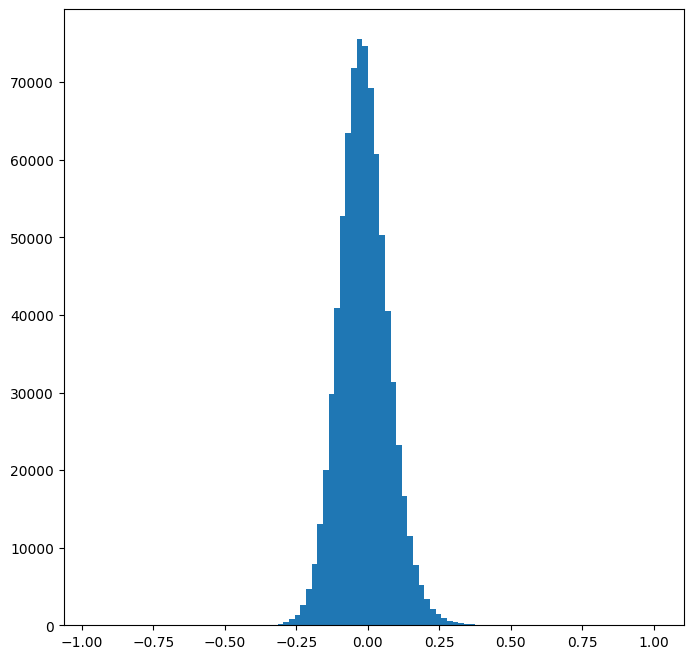

In [22]:
plt.figure(figsize=(8,8))
plt.hist(params, 100)

**This shows a distribution that's heavily concentrated around zero. This explains why quantization can work quite well. With values so concentrated around zero, our scale can be quite small and therefore it is much easier to do an accurate reconstruction as we do not need to represent a large number of values!**

### More Models to Explore

In [23]:
# Text Classification
!wget https://storage.googleapis.com/download.tensorflow.org/models/tflite/text_classification/text_classification_v2.tflite

# Post Estimation
!wget https://storage.googleapis.com/download.tensorflow.org/models/tflite/posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite

--2025-07-10 08:42:00--  https://storage.googleapis.com/download.tensorflow.org/models/tflite/text_classification/text_classification_v2.tflite
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.27, 172.217.15.251, 172.217.164.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 769756 (752K) [application/octet-stream]
Saving to: ‘text_classification_v2.tflite’

text_classification 100%[===================>] 751.71K  --.-KB/s    in 0.005s  

2025-07-10 08:42:00 (140 MB/s) - ‘text_classification_v2.tflite’ saved [769756/769756]

--2025-07-10 08:42:00--  https://storage.googleapis.com/download.tensorflow.org/models/tflite/posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.27, 172.217.15.251, 172.217.164.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.27

In [24]:
TEXT_CLASSIFICATION_MODEL_FILE_NAME = "text_classification_v2.tflite"
POSE_ESTIMATION_MODEL_FILE_NAME = "posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite"

with open(TEXT_CLASSIFICATION_MODEL_FILE_NAME, 'rb') as file:
  text_model_data = file.read()

with open(POSE_ESTIMATION_MODEL_FILE_NAME, 'rb') as file:
  pose_model_data = file.read()

In [25]:
def aggregate_all_weights(buffers):
    weights = []
    for i in range(len(buffers)):
        raw_data = buffers[i]['data']
        if raw_data is not None:
            param_bytes = bytearray(raw_data)
            params = np.frombuffer(param_bytes, dtype=np.float32)
            weights.extend(params.flatten().tolist())

    weights = np.asarray(weights)
    weights = weights[weights<50]
    weights = weights[weights>-50]

    return weights

Lets plot the distribution of the Text Classification Model in log scale


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 3.000e+00, 1.000e+00, 3.000e+00, 4.000e+00, 1.000e+00,
        1.000e+00, 7.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 1.000e+00,
        2.000e+00, 5.000e+00, 5.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 3.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 5.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 3.000e+00,
        3.000e+00, 5.000e+00, 4.000e+00, 1.000e+00, 5.000e+00, 6.000e+00,
        8.000e+00, 1.100e+01, 8.000e+0

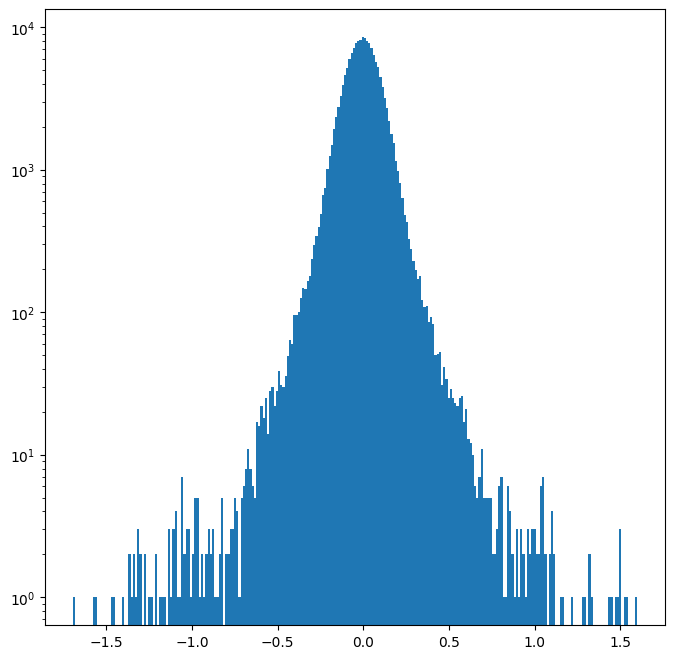

In [30]:
model_dict_temp = CreateDictFromFlatbuffer(text_model_data)
weights = aggregate_all_weights(model_dict_temp['buffers'])

plt.figure(figsize=(8,8))
plt.hist(weights, 256, log=True)

Lets plot the distribution of the Pose Net Model in log scale


(array([1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        2.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 2.000000e+00, 0.000000e+00,
        1.000000e+00, 0.000000e+00, 0.000000e+00, 2.000000e+00,
        1.000000e+00, 0.000000e+00, 1.000000e+00, 2.000000e+00,
        0.000000e+00, 3.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 2.000000e+00,
        1.000000e+00, 0.000000e+00, 0.000000e+00, 2.000000e+00,
        1.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00,
        3.000000e+00, 2.000000e+00, 3.000000e+00, 4.000000e+00,
        5.000000e+00, 4.000000e+00, 5.00

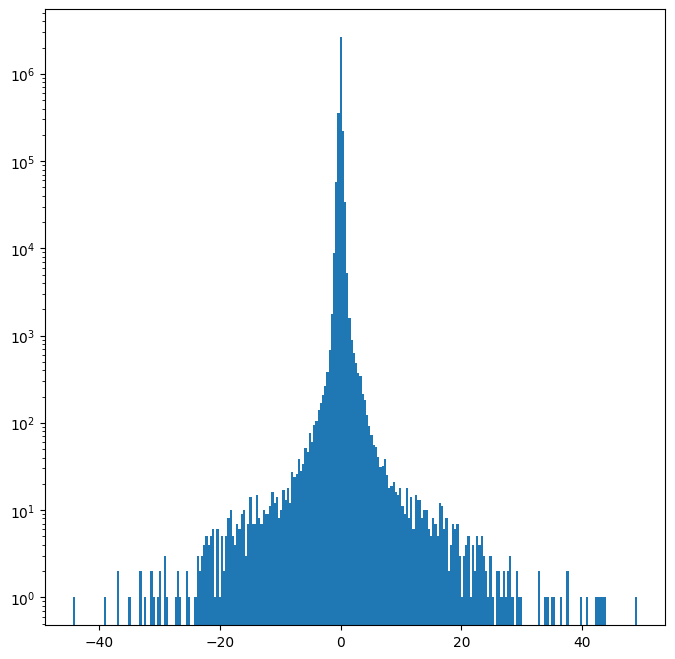

In [31]:
model_dict_temp = CreateDictFromFlatbuffer(pose_model_data)
weights = aggregate_all_weights(model_dict_temp['buffers'][:-1])

plt.figure(figsize=(8,8))
plt.hist(weights, 256, log=True)

**Again we find that most model weights are closely packed around 0.**

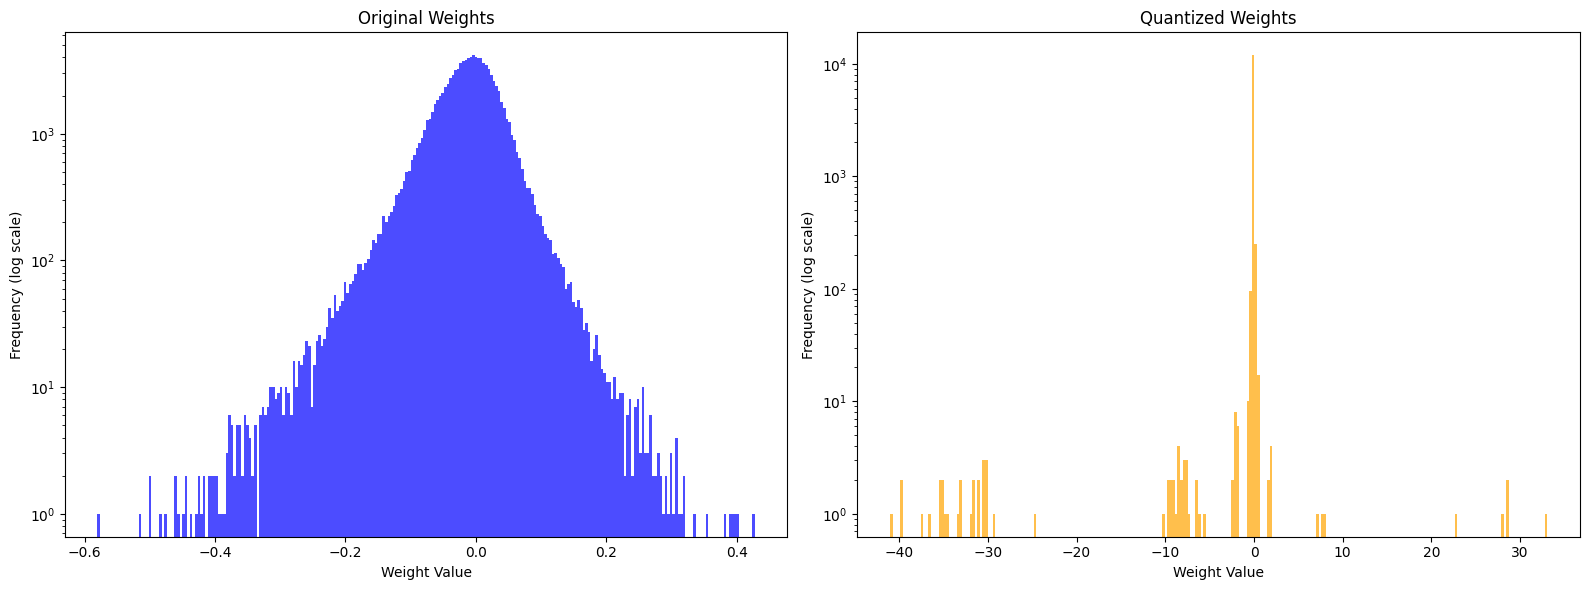

In [36]:
myOwnModel = "/content/mnist_tflite_models/mnist_model.tflite"
QuantMyOwnModel = "/content/mnist_tflite_models/mnist_model_quant.tflite"

with open(myOwnModel, 'rb') as file:
  own_model_data = file.read()

with open(QuantMyOwnModel, 'rb') as file:
  quant_own_model_data = file.read()

own_model_dict_temp = CreateDictFromFlatbuffer(own_model_data)
own_weights = aggregate_all_weights(own_model_dict_temp['buffers'])

quant_own_model_dict_temp = CreateDictFromFlatbuffer(quant_own_model_data)
quant_own_weights = aggregate_all_weights(quant_own_model_dict_temp['buffers'])

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].hist(own_weights, 256, log=True, color='blue', alpha=0.7)
axs[0].set_title('Original Weights')
axs[0].set_xlabel('Weight Value')
axs[0].set_ylabel('Frequency (log scale)')

axs[1].hist(quant_own_weights, 256, log=True, color='orange', alpha=0.7)
axs[1].set_title('Quantized Weights')
axs[1].set_xlabel('Weight Value')
axs[1].set_ylabel('Frequency (log scale)')

plt.tight_layout()
plt.show()